In [0]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as la
import time

start = time.time()
####################################### 5 #######################################

#================================ initialization ================================
c = 1
h = 0.1
hx = h
hy = h
Nx = int(16/hx)
Ny = int(8/hy)
ht = 0.001    #0.99*h/c    0.001584
# ht = 2/4999.8
Nt = int(40/ht)
f = np.zeros((Nt+1,(Nx-1)*(Ny-1)))
u = np.zeros((Nt+1,(Nx-1)*(Ny-1)))
ep = 10**(-3)

#negative laplacian
def NeLap(hx,hy,Nx,Ny):    
    #create Dx and Dy
    Dx = 1/hx*sp.diags([1, -1], [0, -1], shape=(Nx, Nx-1)).toarray()
    Dy = 1/hy*sp.diags([1, -1], [0, -1], shape=(Ny, Ny-1)).toarray()

    #calculate Axx Ayy
    Lxx =Dx.transpose().dot(Dx)
    Lyy =Dy.transpose().dot(Dy)

    #create Lxx and Lyy
    Ix = sp.eye(Nx-1)
    Iy = sp.eye(Ny-1)

    #compute the sparse 2D Laplacian
    A = sp.kron(Iy,Lxx)+sp.kron(Lyy,Ix)

    #negative laplacian
    A = -A
    return A
A = NeLap(hx,hy,Nx,Ny)

# find the stability upper bound
vals, vecs = la.eigsh(A, k=1, which = 'LM')
print('The upper bound is ', 2/abs(vals[0]))


The upper bound is  0.0025006024722023837


In [0]:
# ================================ discretization ===========================
#initial function
def fnut0(x, y):
    u = np.exp(-2*(x-1.5)**2 - 2*(y-1.5)**2)
    return u

#initial conditions
cnt = 0
for j in range(1, Ny):
    for i in range(1, Nx):
        u[0, cnt] = fnut0(i*hx, j*hy)
        cnt+= 1

# k matrix
k = np.zeros((Ny-1, Nx-1))
for j in range(Ny-1):
    for i in range(Nx-1):
        if (i+1)*hx >= 1 and (i+1)*hx<=2 and (j+1)*hy>=1 and (j+1)*hy<=2:
            k[j,i] = 1 
        if (i+1)*hx >= 1 and (i+1)*hx<=3 and (j+1)*hy>=3 and (j+1)*hy<=5: 
            k[j,i] = 1   
        if (i+1)*hy >= 4 and (i+1)*hy<=7 and (j+1)*hx>=4 and (j+1)*hx<=7: 
            k[j,i] = 1  
        if (i+1)*hy >= 9 and (i+1)*hy<=12 and (j+1)*hx>=4 and (j+1)*hx<=6: 
            k[j,i] = 1
        if (i+1)*hy >= 13 and (i+1)*hy<=15 and (j+1)*hx>=1 and (j+1)*hx<=3: 
            k[j,i] = 1
k = k.reshape((Nx-1)*(Ny-1))

#Jacobian
def Jacobian(u):
    diag = sp.diags(u, 0, format = 'csc')    
    J = sp.eye(u.shape[0])  + A - 2*diag
    return J

#f function
def fnf(u):
    f =   u - np.multiply(u,u)
    f =  np.multiply(f,k)
    f = f + A.dot(u)
    return f

# function compute vi
def fnvi(ui,u):
    LHS = sp.eye((Nx-1)*(Ny-1)) - ht*Jacobian(ui) 
    RHS = ui - u - ht*fnf(ui)
    RHS = sp.csr_matrix(RHS).transpose()
    vi = la.spsolve(LHS, RHS)
    return vi

In [0]:
#====================================== solver NR =================================
tcnt = 0
icntList = []
res = []
resPlain = [] #collect the residual for plotting
total = 0
for i in range(Nt):
    ui0 = np.copy(u[tcnt, :])
    ui = np.copy(u[tcnt, :]) #initial condition
    resTemp = []
    icnt = 0
    while np.linalg.norm(ui - ui0 - ht*fnf(ui)  ) > ep :
        resTemp.append(np.linalg.norm(ui - ui0 - ht*fnf(ui)))
        resPlain.append(np.linalg.norm(ui - ui0 - ht*fnf(ui)))
        vi = fnvi(ui, u[tcnt, :])
        ui = ui - vi 
        icnt+=1
        total+= 1
    resTemp.append(np.linalg.norm(ui - ui0 - ht*fnf(ui))) #collect the last er norm
    resPlain.append(np.linalg.norm(ui - ui0 - ht*fnf(ui))) #collect the last er norm
    res.append(resTemp)
    icntList.append(icnt)
    tcnt += 1
    u[tcnt,:] = np.copy(ui)

#save the solutions
uNR = np.copy(u)
icntNR = icntList
resNR = res

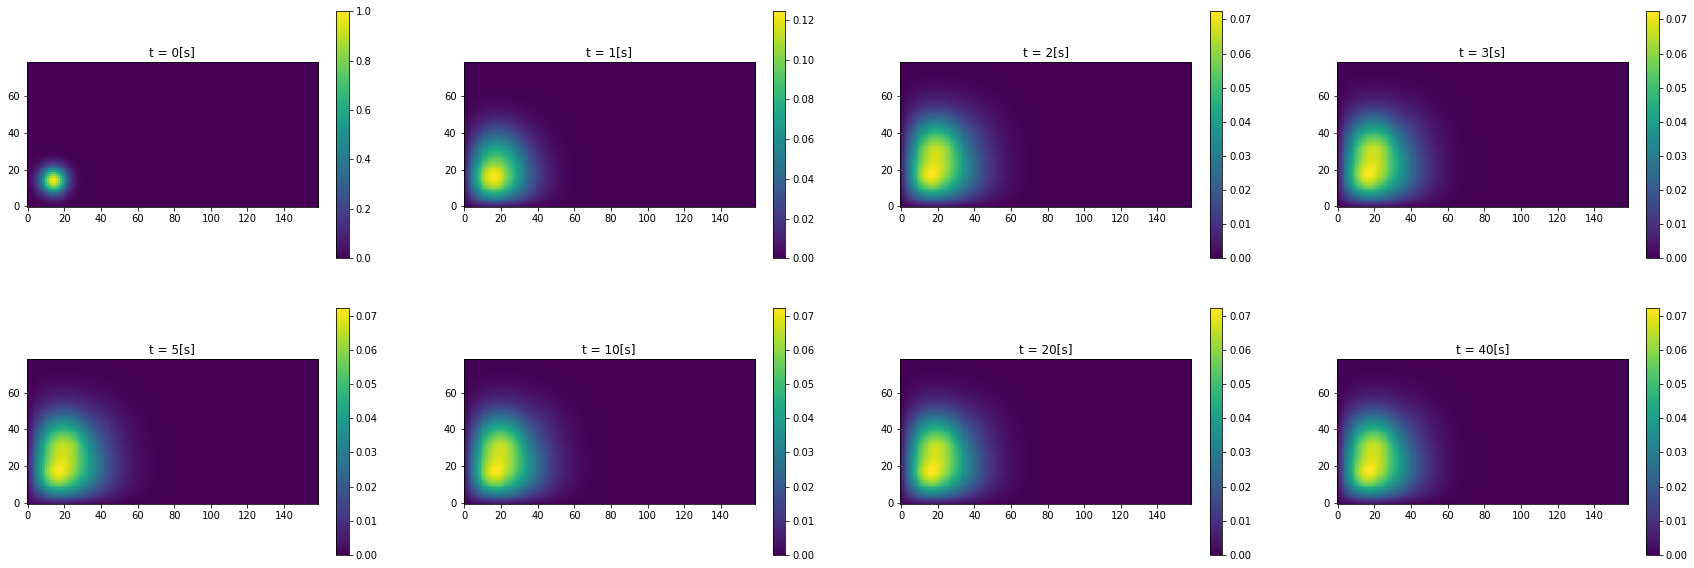

The inner iterations at each time step are:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

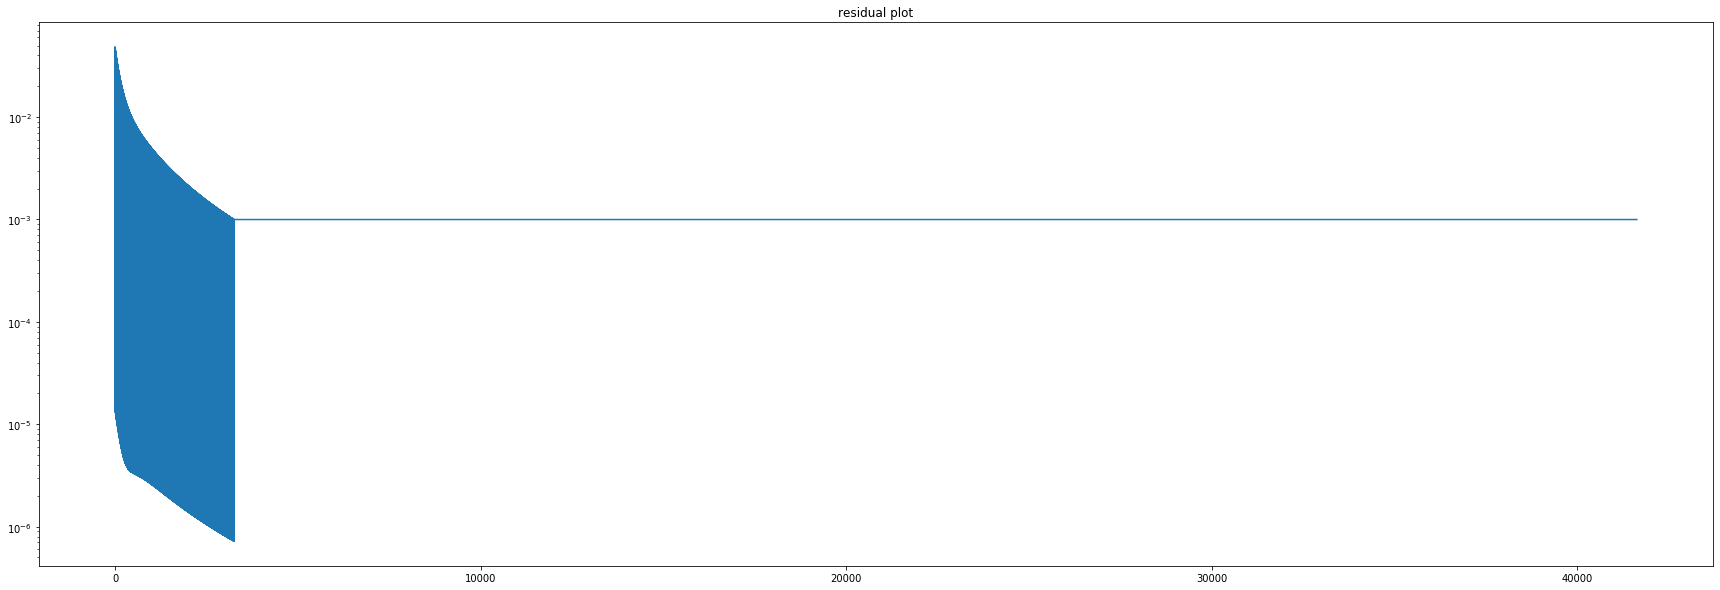

In [0]:
#============================plot the results with color bar======================
#select which method to print
uPrint = uNR
icntPrint = icntNR
resPrint = resNR

#plot figures
fig, axs = plt.subplots(2, 4,figsize=(30,10))

im1 = axs[0,0].imshow(uPrint[int(0/ht), :].reshape((Ny-1,Nx-1)))
fig.colorbar(im1, ax=axs[0, 0])
axs[0, 0].set_title("t = 0[s]")
axs[0, 0].invert_yaxis()

im2 = axs[0,1].imshow(uPrint[int(1/ht), :].reshape((Ny-1,Nx-1)))
fig.colorbar(im2, ax=axs[0, 1])
axs[0, 1].set_title("t = 1[s]")
axs[0, 1].invert_yaxis()

im3 = axs[0,2].imshow(uPrint[int(2/ht), :].reshape((Ny-1,Nx-1)))
fig.colorbar(im3, ax=axs[0, 2])
axs[0, 2].set_title("t = 2[s]")
axs[0, 2].invert_yaxis()

im4 = axs[0,3].imshow(uPrint[int(3/ht), :].reshape((Ny-1,Nx-1)))
fig.colorbar(im4, ax=axs[0, 3])
axs[0, 3].set_title("t = 3[s]")
axs[0, 3].invert_yaxis()

im1 = axs[1,0].imshow(uPrint[int(5/ht), :].reshape((Ny-1,Nx-1)))
fig.colorbar(im1, ax=axs[1, 0])
axs[1, 0].set_title("t = 5[s]")
axs[1, 0].invert_yaxis()

im2 = axs[1,1].imshow(uPrint[int(10/ht), :].reshape((Ny-1,Nx-1)))
fig.colorbar(im2, ax=axs[1, 1])
axs[1, 1].set_title("t = 10[s]")
axs[1, 1].invert_yaxis()

im3 = axs[1,2].imshow(uPrint[int(20/ht), :].reshape((Ny-1,Nx-1)))
fig.colorbar(im3, ax=axs[1, 2])
axs[1, 2].set_title("t = 20[s]")
axs[1, 2].invert_yaxis()

im4 = axs[1,3].imshow(uPrint[int(40/ht), :].reshape((Ny-1,Nx-1)))
fig.colorbar(im4, ax=axs[1, 3])
axs[1, 3].set_title("t = 40[s]")
axs[1, 3].invert_yaxis()
plt.show()

#show the plots, number of inner iterations, and the residual behaviour

print('The inner iterations at each time step are: ' , icntPrint)
print('Total time steps are: ', len(icntPrint))
print('The total inner iteration times are: ', total)
print('The residuals are: ', resPrint)

plt.figure(figsize=(30,10))
plt.plot(resPlain)
plt.title('residual plot')
plt.yscale('log')
# plt.xlim(6600, 6800)
# plt.ylim(0, 0.01)


# #========================================unify color bar==============================
# #store solution for plotting
# u_uni = np.zeros((8, Ny-1, Nx-1))
# u_uni[0, : , :] = uPrint[int(0/ht), :].reshape((Ny-1,Nx-1))
# u_uni[1, : , :] = uPrint[int(1/ht), :].reshape((Ny-1,Nx-1))
# u_uni[2, : , :] = uPrint[int(2/ht), :].reshape((Ny-1,Nx-1))
# u_uni[3, : , :] = uPrint[int(3/ht), :].reshape((Ny-1,Nx-1))
# u_uni[4, : , :] = uPrint[int(5/ht), :].reshape((Ny-1,Nx-1))
# u_uni[5, : , :] = uPrint[int(10/ht), :].reshape((Ny-1,Nx-1))
# u_uni[6, : , :] = uPrint[int(20/ht), :].reshape((Ny-1,Nx-1))
# u_uni[7, : , :] = uPrint[int(40/ht), :].reshape((Ny-1,Nx-1))

# fig, axes = plt.subplots(2, 4,figsize=(20,10))
# cnt = 0
# for ax in axes.flat:
#     im = ax.imshow(u_uni[cnt, : , : ], vmin=-0.000, vmax=0.6)
#     ax.invert_yaxis()
#     ax.set_title('t = ' +str(cnt)+'[s]')
#     cnt += 1
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
# fig.colorbar(im, cax=cbar_ax)
# plt.show()

end = time.time()
elapsed = end - start
print('Time cost: ',elapsed)